# Face Landmarks Detection

In [2]:
import itertools
from time import time

import cv2
import matplotlib.pyplot as plt
import mediapipe as mp
import numpy as np

In [3]:
def display_image(image, title: str):
    plt.figure(figsize=(10, 10))
    plt.title(title)
    plt.axis('off')
    plt.imshow(image)
    plt.show()

In [4]:
def custom_print(message: str):
    return print(f'{"-" * 50}\n{message}\n')

In [5]:
# Initialize the mediapipe face detection class.
mp_face_detection = mp.solutions.face_detection

# Set up the face detection function.
face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)

# Initialize the mediapipe drawing class.
mp_drawing = mp.solutions.drawing_utils

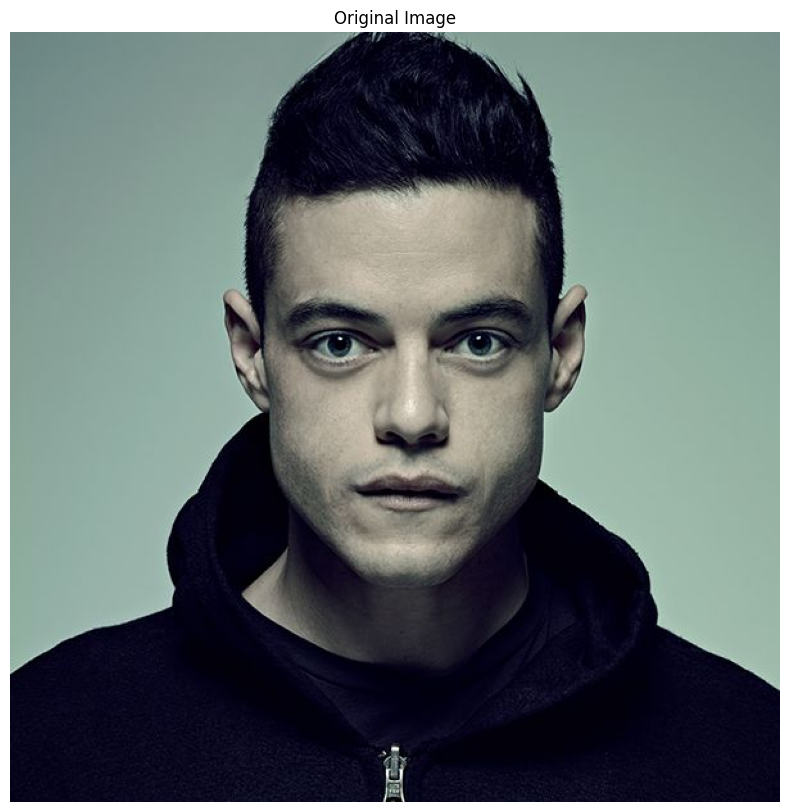

In [6]:
# Read the image
sample_img = cv2.imread('images/face-1.jpg')
rgb_img = sample_img[:, :, ::-1]
display_image(rgb_img, "Original Image")

# Perform face detection
1. Right eye
2. Left eye
3. Nose
4. Mouth center
5. Right ear tragion
6. Left ear tragion

In [7]:
# Perform face detection
face_detection_results = face_detection.process(rgb_img)

# Show results
if face_detection_results.detections:
    for index, face in enumerate(face_detection_results.detections):
        custom_print(f'FACE NUMBER: {index + 1}')
        custom_print(f'FACE CONFIDENCE: {round(face.score[0], 2)}')

        # Get the face bounding box and face key points coordinates.
        face_data = face.location_data
        custom_print(f'FACE BOUNDING BOX:\n{face_data.relative_bounding_box}')

        # Iterate two times as we only want to display first two key points of each detected face.
        for i in range(2):
            custom_print(mp_face_detection.FaceKeyPoint(i).name)
            print(face_data.relative_keypoints[mp_face_detection.FaceKeyPoint(i).value])

--------------------------------------------------
FACE NUMBER: 1

--------------------------------------------------
FACE CONFIDENCE: 0.93

--------------------------------------------------
FACE BOUNDING BOX:
xmin: 0.28991297
ymin: 0.27544057
width: 0.4553782
height: 0.455297


--------------------------------------------------
RIGHT_EYE

x: 0.4281107
y: 0.41215307

--------------------------------------------------
LEFT_EYE

x: 0.6111026
y: 0.41255483



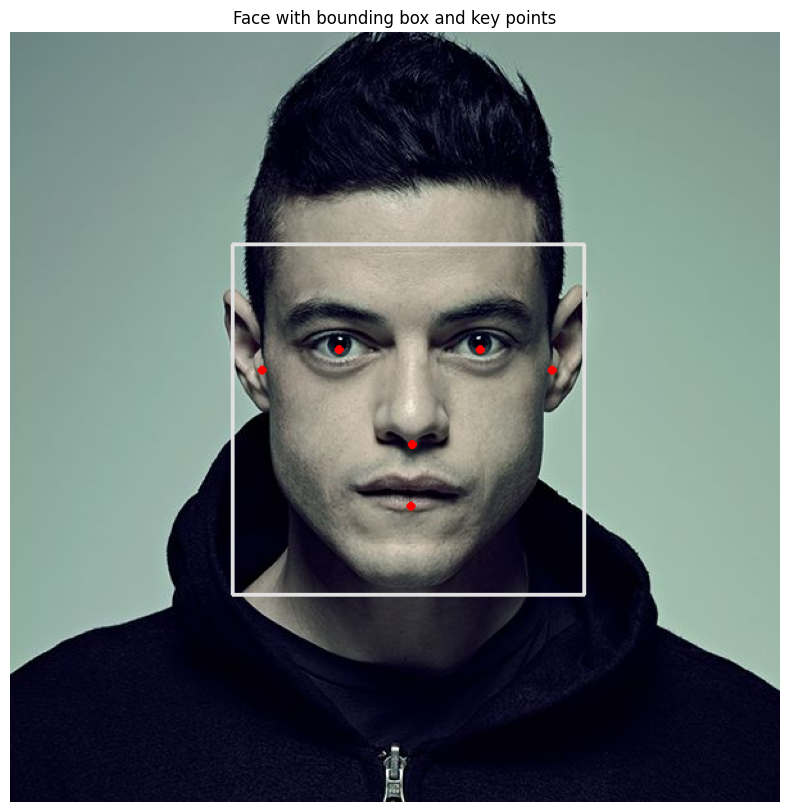

In [8]:
# Draw the bounding box key points
img_copy = rgb_img.copy()

if face_detection_results.detections:
    # Iterate over the found faces.
    for index, face in enumerate(face_detection_results.detections):
        # Draw the face bounding box and key points on the copy of the sample image.
        mp_drawing.draw_detection(
            image=img_copy, detection=face,
            keypoint_drawing_spec=mp_drawing.DrawingSpec(
                color=(255, 0, 0),
                thickness=2,
                circle_radius=2
            )
        )

# Display the resultant image with the bounding box and key points drawn,
display_image(img_copy, "Face with bounding box and key points")

# Face Landmarks detection

In [9]:
# Initialize the mediapipe face mesh class
mp_face_mesh = mp.solutions.face_mesh

# Set up the face landmarks function for images
face_mesh_images = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=2,
    min_detection_confidence=0.5
)

# Set up the face landmarks function for videos
face_mesh_videos = mp_face_mesh.FaceMesh(
    static_image_mode=False,
    max_num_faces=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.3
)

# Initialize the mediapipe drawing styles class
mp_drawing_styles = mp.solutions.drawing_styles

In [10]:
face_mesh_results = face_mesh_images.process(rgb_img)

# Get the list of indexes of the left and right eye.
LEFT_EYE_indexes = list(set(itertools.chain(*mp_face_mesh.FACEMESH_LEFT_EYE)))
RIGHT_EYE_indexes = list(set(itertools.chain(*mp_face_mesh.FACEMESH_RIGHT_EYE)))

if face_mesh_results.multi_face_landmarks:
    for index, face_landmarks in enumerate(face_mesh_results.multi_face_landmarks):
        custom_print(f'FACE NUMBER: {index + 1}')

        custom_print(f'LEFT EYE LANDMARKS:\n')
        for eye_index in LEFT_EYE_indexes[:2]:
            print(face_landmarks.landmark[eye_index])

        custom_print(f'RIGHT EYE LANDMARKS:\n')
        for eye_index in RIGHT_EYE_indexes[:2]:
            print(face_landmarks.landmark[eye_index])

--------------------------------------------------
FACE NUMBER: 1

--------------------------------------------------
LEFT EYE LANDMARKS:


x: 0.58434546
y: 0.39823008
z: -0.008555503

x: 0.59933
y: 0.3921302
z: -0.011784707

--------------------------------------------------
RIGHT EYE LANDMARKS:


x: 0.41179177
y: 0.39580357
z: -0.011861917

x: 0.39392933
y: 0.40655148
z: 0.0081479745



In [11]:
def detect_face_landmarks(image, face_mesh):
    rgb_image = image[:, :, ::-1]
    results = face_mesh.process(rgb_image)
    output_image = rgb_image.copy()

    if results.multi_face_landmarks:
        for face_landmarks in results.multi_face_landmarks:
            mp_drawing.draw_landmarks(
                image=output_image, landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_TESSELATION,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style()
            )
            mp_drawing.draw_landmarks(
                image=output_image, landmark_list=face_landmarks,
                connections=mp_face_mesh.FACEMESH_CONTOURS,
                landmark_drawing_spec=None,
                connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_contours_style()
            )

    return output_image, results

In [12]:
def test_detect_facial_landmarks(image_src):
    image = cv2.imread(image_src)
    image, results = detect_face_landmarks(image, face_mesh_images)
    display_image(image, "Face with face mesh drawn")

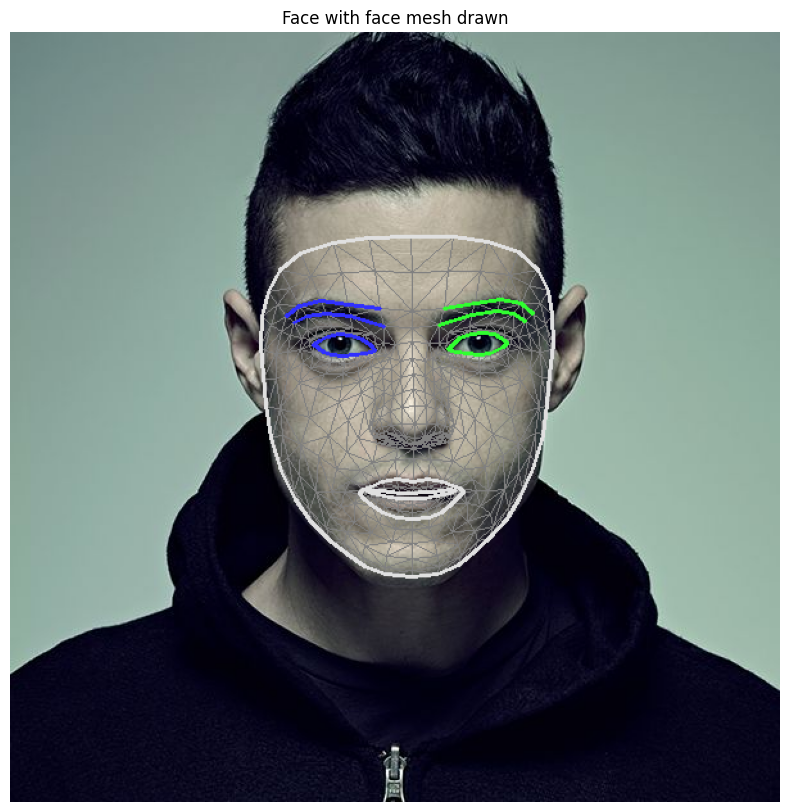

In [13]:
test_detect_facial_landmarks('images/face-1.jpg')

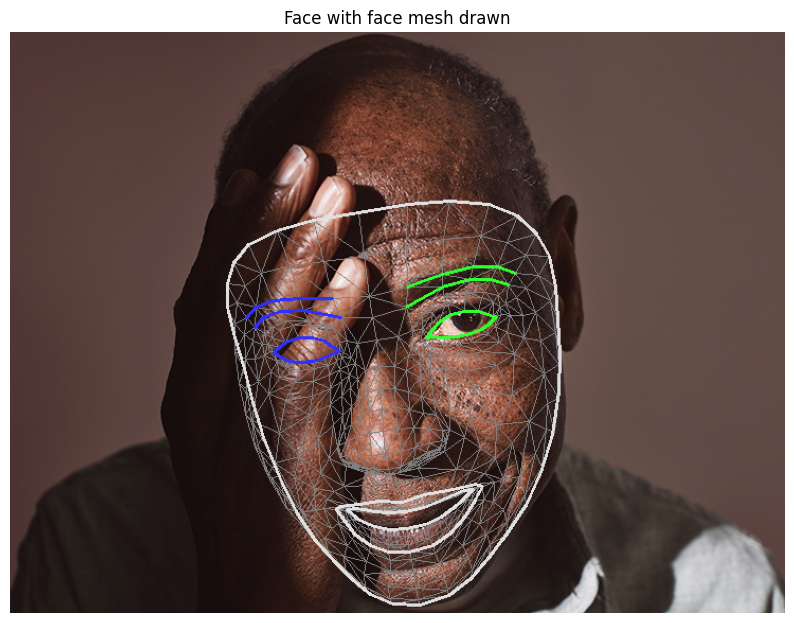

In [14]:
test_detect_facial_landmarks('images/face-2.jpg')

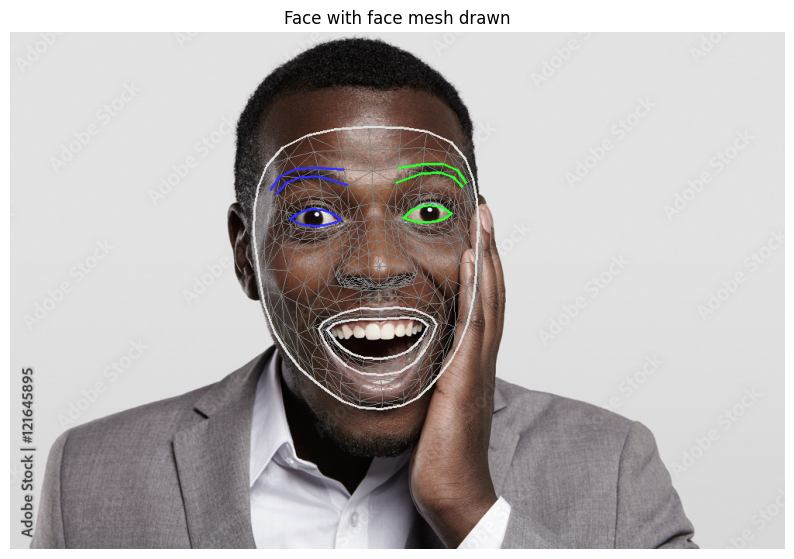

In [15]:
test_detect_facial_landmarks('images/face-3.jpg')

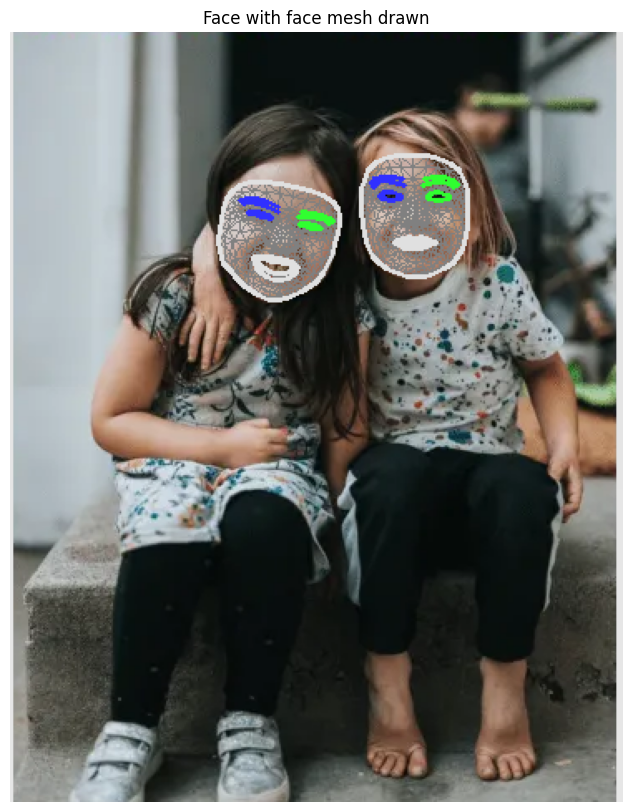

In [16]:
test_detect_facial_landmarks('images/face-4.jpg')

# Face Landmarks detection on real time webcam feed

In [17]:
camera_video = cv2.VideoCapture(1)
cv2.namedWindow('Face Landmarks Detection', cv2.WINDOW_NORMAL)
time1 = 0

cv2.namedWindow('Face Landmarks Detection', cv2.WINDOW_NORMAL)
while camera_video.isOpened():
    ok, frame = camera_video.read()
    if not ok:
        continue

    # Flip the frame horizontally for natural (selfie-view) visualization.
    frame = cv2.flip(frame, 1)

    frame, _ = detect_face_landmarks(frame, face_mesh_videos)
    time2 = time()
    if (time2 - time1) > 0:
        frames_per_second = 1.0 / (time2 - time1)
        cv2.putText(
            frame, f'FPS: {int(frames_per_second)}',
            (10, 30), cv2.FONT_HERSHEY_PLAIN, 2, (0, 255, 0), 3
        )

    time1 = time2
    cv2.imshow('Face Landmarks Detection', frame)

    k = cv2.waitKey(27)
    if k == 27:
        break

camera_video.release()
cv2.destroyAllWindows()

# Face expression recognition

In [18]:
def get_size(image, face_landmarks, indexes):
    image_height, image_width, _ = image.shape

    # Extract landmarks for the given indexes
    landmarks = [
        [
            int(face_landmarks.landmark[i].x * image_width),
            int(face_landmarks.landmark[i].y * image_height)
        ]
        for i in itertools.chain(*indexes)
    ]

    _, _, width, height = cv2.boundingRect(np.array(landmarks))
    return width, height, np.array(landmarks)

In [19]:
FACE_MESH_CONFIG = {
    'MOUTH': {
        "indexes": mp.solutions.face_mesh.FACEMESH_LIPS,
        "threshold": 15,
    },
    'LEFT EYE': {
        "indexes": mp.solutions.face_mesh.FACEMESH_LEFT_EYE,
        "threshold": 5,
    },
    'RIGHT EYE': {
        "indexes": mp.solutions.face_mesh.FACEMESH_RIGHT_EYE,
        "threshold": 5,
    },
}


def is_open(image, face_mesh_results):
    h, w, _ = image.shape
    faces_status = []

    for face_landmarks in face_mesh_results.multi_face_landmarks:
        face_status = {}

        for part, config in FACE_MESH_CONFIG.items():
            _, part_height, _ = get_size(image, face_landmarks, config["indexes"])
            _, face_height, _ = get_size(image, face_landmarks, mp.solutions.face_mesh.FACEMESH_FACE_OVAL)

            is_open = (part_height / face_height) * 100 > config["threshold"]
            face_status[part] = True if is_open else False

        faces_status.append(face_status)
    return faces_status

In [20]:
def display_image_with_open_status_results(image, open_status):
    row_counter = 1
    for face_index, face_status in enumerate(open_status):
        for part_index, (part, status) in enumerate(face_status.items()):
            color = (0, 255, 0) if status else (255, 0, 0)
            cv2.putText(
                image, f'{face_index + 1}: {part}: {status}',
                (10, row_counter * 35), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1
            )
            row_counter += 1
    display_image(image, "Face with facial expression status")

In [21]:
def test_is_open(image_src: str):
    original_image = cv2.imread(image_src)
    image = cv2.flip(original_image, 1)

    image, face_mesh_results = detect_face_landmarks(image, face_mesh_images)
    open_status = is_open(image, face_mesh_results)

    display_image_with_open_status_results(image, open_status)

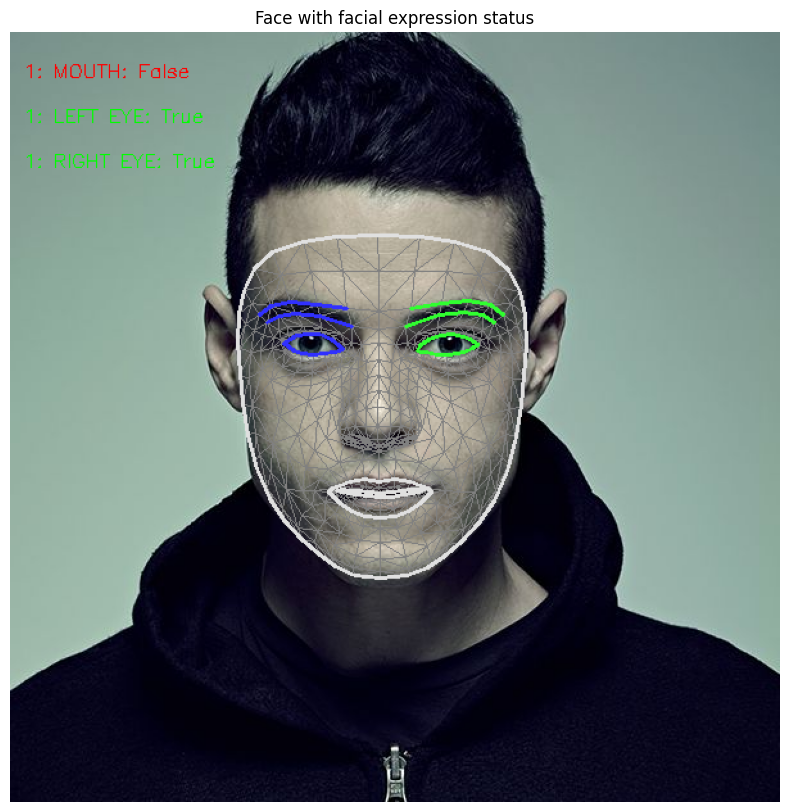

In [22]:
test_is_open('images/face-1.jpg')

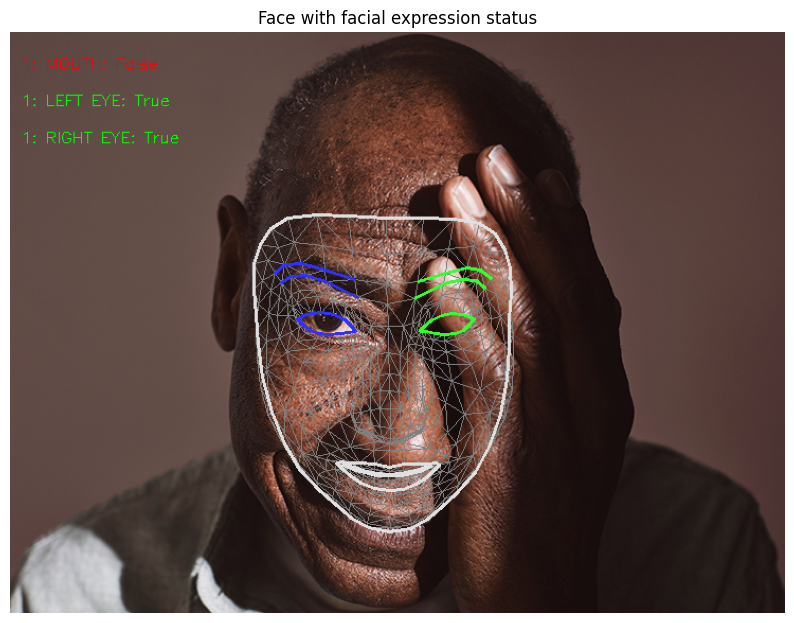

In [23]:
test_is_open('images/face-2.jpg')

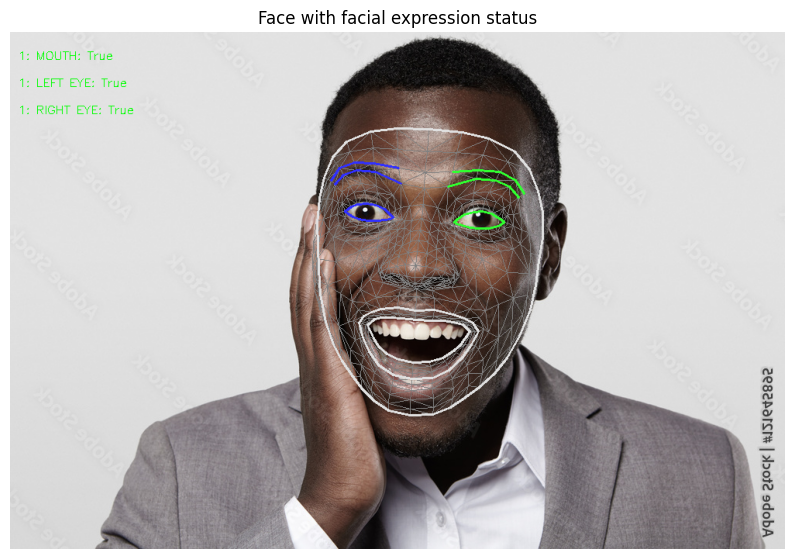

In [24]:
test_is_open('images/face-3.jpg')

# Filter controlled by Facial expressions

In [25]:
def resize_filter_to_face(filter_img, face_part_height):
    """Resizes filter image based on face part's height."""

    required_height = int(face_part_height * 2.5)
    filter_img_height, filter_img_width, _ = filter_img.shape
    new_width = int((required_height / filter_img_height) * filter_img_width)

    return cv2.resize(filter_img, (new_width, required_height))

In [36]:
def get_overlay_location(face_part, center, filter_dims):
    """Calculates the overlay position based on the face part."""

    filter_img_width, filter_img_height = filter_dims
    return int(center[0] - filter_img_width / 2), int(center[1] - filter_img_height / 2)

In [37]:
def apply_filter_to_region(ROI, filter_img):
    """Applies filter image to a region of interest."""

    grayscale = cv2.cvtColor(filter_img, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(grayscale, 25, 255, cv2.THRESH_BINARY_INV)

    masked_ROI = cv2.bitwise_and(ROI, ROI, mask=mask)
    return cv2.add(masked_ROI, filter_img)

In [38]:
def overlay(image, filter_img, face_landmarks, face_part, indexes):
    annotated_image = image.copy()

    try:
        _, face_part_height, landmarks = get_size(image, face_landmarks, indexes)
        resized_filter_img = resize_filter_to_face(filter_img, face_part_height)
        center = landmarks.mean(axis=0).astype("int")
        location = get_overlay_location(face_part, center, resized_filter_img.shape[:2])

        # Retrieve the region of interest from the image where the filter image will be placed.
        filter_img_height, filter_img_width, _ = resized_filter_img.shape
        ROI = annotated_image[
              location[1]:location[1] + filter_img_height,
              location[0]:location[0] + filter_img_width
              ]

        resultant_image = apply_filter_to_region(ROI, resized_filter_img)

        annotated_image[
        location[1]:location[1] + filter_img_height,
        location[0]:location[0] + filter_img_width
        ] = resultant_image

    except Exception as e:
        print(f"Error: {e}")

    return annotated_image

In [39]:
def test_overlay(image_src: str, filter_img_src: str):
    image = cv2.imread(image_src)
    filter_img = cv2.imread(filter_img_src)
    image, face_mesh_results = detect_face_landmarks(image, face_mesh_images)
    face_landmarks = face_mesh_results.multi_face_landmarks[0]
    image = overlay(image, filter_img, face_landmarks, "LEFT EYE", mp_face_mesh.FACEMESH_LEFT_EYE)
    image = overlay(image, filter_img, face_landmarks, "RIGHT EYE", mp_face_mesh.FACEMESH_RIGHT_EYE)

    display_image(image, "Face with filter")

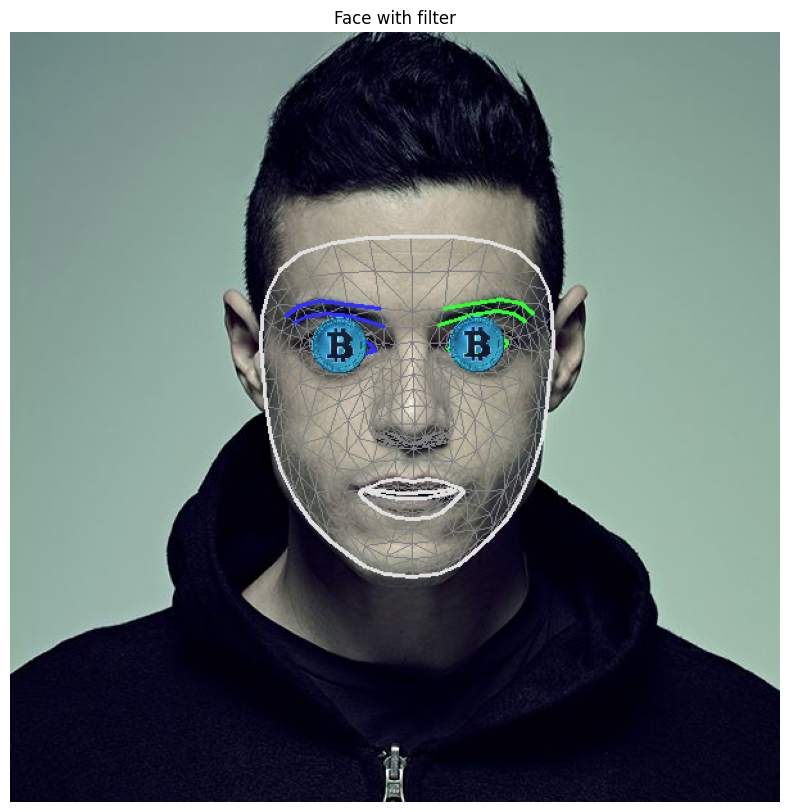

In [40]:
test_overlay('images/face-1.jpg', 'images/filter.png')

In [41]:
def read_animation_frame(animation, frame_counter):
    _, frame = animation.read()
    frame_counter += 1
    if frame_counter == animation.get(cv2.CAP_PROP_FRAME_COUNT):
        animation.set(cv2.CAP_PROP_POS_FRAMES, 0)
        frame_counter = 0
    return frame, frame_counter

In [43]:
camera_video = cv2.VideoCapture(1)
cv2.namedWindow('Face Filter', cv2.WINDOW_NORMAL)

filter_image = cv2.imread('images/filter.png')
mouth_frame_counter = 0

while camera_video.isOpened():
    ok, frame = camera_video.read()
    if not ok:
        continue
    
    frame = cv2.flip(frame, 1)
    _, face_mesh_results = detect_face_landmarks(frame, face_mesh_videos)
    if face_mesh_results.multi_face_landmarks:
        face_open_status = is_open(frame, face_mesh_results)

        for index, face_landmarks in enumerate(face_mesh_results.multi_face_landmarks):
            current_face = face_open_status[index]

            # Overlay the left eye image on the frame 
            if current_face['LEFT EYE']:
                frame = overlay(frame, filter_image, face_landmarks, 'LEFT EYE', mp_face_mesh.FACEMESH_LEFT_EYE)

            # Overlay the right eye image on the frame
            if current_face['RIGHT EYE']:
                frame = overlay(frame, filter_image, face_landmarks, 'RIGHT EYE', mp_face_mesh.FACEMESH_RIGHT_EYE)
                
            # Overlay the mouth animation on the frame
            if current_face['MOUTH']:
                frame = overlay(frame, filter_image, face_landmarks, 'MOUTH', mp_face_mesh.FACEMESH_LIPS)

    cv2.imshow('Face Filter', frame)
    k = cv2.waitKey(27)
    if k == 27:
        break

camera_video.release()
cv2.destroyAllWindows()

## References

[Youtube Video](https://www.youtube.com/watch?v=QERl1-ckFr8) 
[Blog post Link](https://bleedaiacademy.com/facial-landmark-detection-with-mediapipe-creating-animated-snapchat-filters/) 
